In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from itertools import combinations
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
import pandas as pd
from scipy.stats import spearmanr, kendalltau
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn.ensemble import StackingRegressor

# 1) Universe
tickers = ['AAPL','MSFT','GOOGL','AMZN','JPM','BAC','WMT','XOM','JNJ']
start = datetime(1990,1,1)
end = datetime.today()

# 2) Download daily OHLCV from Stooq
def download_stooq(ts, start, end):
    frames = []
    for t in ts:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
        except Exception as e:
            print(f"Error downloading {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(tickers, start, end)
# Extract OHLC and Volume
open_ = raw.xs('Open', level=1, axis=1)
high  = raw.xs('High', level=1, axis=1)
low   = raw.xs('Low',  level=1, axis=1)
close = raw.xs('Close',level=1, axis=1)
vol   = raw.xs('Volume', level=1, axis=1)

# Compute daily returns on close
rets = close.pct_change().dropna()

# 3) Combine raw price/volume features
feat_list = []
feat_list.append(open_.add_suffix('_open'))
feat_list.append(high.add_suffix('_high'))
feat_list.append(low.add_suffix('_low'))
feat_list.append(vol.add_suffix('_vol'))

# 4) Rolling stats on returns (21-day)
W = 21
for t in tickers:
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W).mean(),
        f"{t}_roll_var":  r.rolling(W).var(),
        f"{t}_roll_skew": r.rolling(W).skew()
    }))

# 4.1) Additional rolling stats on returns (5-day)
W_short = 5
for t in tickers:
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"{t}_roll_mean5": r.rolling(W_short).mean(),
        f"{t}_roll_var5":  r.rolling(W_short).var(),
        f"{t}_roll_skew5": r.rolling(W_short).skew()
    }))

# 4.2) Additional momentum and volatility features
for t in tickers:
    r = rets[t]
    feat_list.append((r - r.shift(5)).rename(f"{t}_mom5"))               # 5-day momentum
    feat_list.append(r.rolling(21).std().rename(f"{t}_vol21"))           # 21-day volatility
    feat_list.append(r.rolling(21).kurt().rename(f"{t}_roll_kurt"))      # 21-day kurtosis

# 5) Correlations AAPL vs others
base = rets['AAPL']
for t in tickers:
    if t == 'AAPL': continue
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"AAPL_{t}_pear":  base.rolling(W).corr(r),
        f"AAPL_{t}_spear": base.rolling(W).apply(lambda w: spearmanr(w, r.loc[w.index])[0], raw=False),
        f"AAPL_{t}_kend":  base.rolling(W).apply(lambda w: kendalltau(w, r.loc[w.index])[0], raw=False)
    }))

# 6) Technical indicators
ema_periods = [3, 6, 12]
for p in ema_periods:
    ema = close.ewm(span=p, adjust=False).mean()
    feat_list.append(ema.pct_change().add_suffix(f"_ema{p}"))
# MACD
macd = close.ewm(span=12, adjust=False).mean() - close.ewm(span=26, adjust=False).mean()
feat_list.append(macd.add_suffix("_macd"))
# RSI

def compute_rsi(series, period=14):
    delta = series.diff()
    up    = delta.clip(lower=0)
    down  = -delta.clip(upper=0)
    ma_up   = up.ewm(alpha=1/period, min_periods=period).mean()
    ma_down = down.ewm(alpha=1/period, min_periods=period).mean()
    return 100 - (100/(1 + ma_up/ma_down))
feat_list.append(close.apply(lambda c: compute_rsi(c, 14)).add_suffix("_rsi14"))

# Bollinger Bands (20-day)
window = 20
for t in tickers:
    ma = close[t].rolling(window).mean()
    std = close[t].rolling(window).std()
    feat_list.append(pd.DataFrame({
        f"{t}_bb_upper": ma + 2*std,
        f"{t}_bb_lower": ma - 2*std,
        f"{t}_bb_width": (ma + 2*std) - (ma - 2*std)
    }))

# On-Balance Volume (OBV)
for t in tickers:
    obv = (np.sign(close[t].diff()) * vol[t]).fillna(0).cumsum()
    feat_list.append(obv.rename(f"{t}_obv"))

# Average True Range (ATR)
high_low = high - low
high_prev_close = (high - close.shift(1)).abs()
low_prev_close = (low - close.shift(1)).abs()
tr = pd.DataFrame(index=close.index)
for t in tickers:
    tr[t] = pd.concat([high_low[t], high_prev_close[t], low_prev_close[t]], axis=1).max(axis=1)
for t in tickers:
    atr = tr[t].rolling(window).mean()
    feat_list.append(atr.rename(f"{t}_atr"))

# Stochastic Oscillator %K (14-day)
for t in tickers:
    lowest_low = low[t].rolling(14).min()
    highest_high = high[t].rolling(14).max()
    stoch = 100 * (close[t] - lowest_low) / (highest_high - lowest_low)
    feat_list.append(stoch.rename(f"{t}_stoch_k"))

# Williams %R (14-day)
for t in tickers:
    highest_high = high[t].rolling(14).max()
    lowest_low = low[t].rolling(14).min()
    willr = -100 * (highest_high - close[t]) / (highest_high - lowest_low)
    feat_list.append(willr.rename(f"{t}_willr"))

# 7) Calendar features
cal = pd.DataFrame(index=close.index)
cal['dow']   = cal.index.dayofweek
cal['month'] = cal.index.month
feat_list.append(cal)

# 8) Macro from FRED (sans PMI)
fred_codes = {
    'FedFunds':    'FEDFUNDS',
    'US10Y':       'DGS10',
    'CPI':         'CPIAUCSL',
    'Unemployment':'UNRATE'
}
macro = pd.DataFrame(index=close.index)
for name, code in fred_codes.items():
    try:
        dfm = pdr.DataReader(code, 'fred', start, end)
        dfm = dfm.reindex(close.index).fillna(method='ffill')
        macro[name] = dfm[code]
    except Exception as e:
        print(f"Warning: could not load {name} ({code}): {e}")
feat_list.append(macro.pct_change().add_suffix("_mom1"))

# 8.1) Cross-asset interaction features
for t1, t2 in combinations(tickers, 2):
    feat_list.append((rets[t1] * rets[t2]).rename(f"{t1}_{t2}_ret_prod"))
    feat_list.append((rets[t1] - rets[t2]).rename(f"{t1}_{t2}_ret_diff"))
    feat_list.append((rets[t1] / rets[t2]).rename(f"{t1}_{t2}_ret_ratio"))

# 9) Combine all features
features = pd.concat(feat_list, axis=1).dropna()

# 10) Target: AAPL next-day return
target = rets['AAPL'].shift(-1).loc[features.index].rename('target')
features, target = features.align(target, join='inner', axis=0)

# 11) Create df_all with features + target
df_all = features.copy()
df_all['target'] = target

# 12) Correlation scores of features vs target
pearson = df_all.drop(columns='target').corrwith(df_all['target'])
spearman = df_all.drop(columns='target').apply(lambda x: spearmanr(x, df_all['target'], nan_policy='omit')[0])
kendall = df_all.drop(columns='target').apply(lambda x: kendalltau(x, df_all['target'], nan_policy='omit')[0])

corr_df = pd.DataFrame({
    'pearson_abs': pearson.abs(),
    'spearman_abs': spearman.abs(),
    'kendall_abs': kendall.abs()
})
corr_df['max_abs_corr'] = corr_df.max(axis=1)
corr_df = corr_df.sort_values('max_abs_corr', ascending=False)
print("Top 20 features by absolute correlation with next-day AAPL return:")
print(corr_df.head(20))

In [ ]:
import pandas as pd
import numpy as np
from itertools import combinations

def generate_strong_features(df: pd.DataFrame,
                             target: pd.Series,
                             lags=[1,5,10],
                             windows=[5,10,21,50],
                             stats=['mean','var','std','skew','kurt'],
                             min_samples=200,
                             corr_multiplier=2,
                             max_features=10):
    """
    Génère des features de façon itérative et quasi-infinie tant qu'on n'a pas atteint max_features.
    À chaque itération, on teste :
      - Lags (shift)
      - Différences
      - Rolling stats (mean, var, std, skew, kurt)
      - Produits, ratios, comparaisons binaires 
    Les features validées sont ajoutées immédiatement au pool pour de nouvelles combinaisons.
    Critère de validation : pour au moins une fenêtre W,
      * abs(moyenne corr.) > corr_multiplier * variance corr.
      * au moins min_samples de corrélations non-nulles.
    Imprime le nom dès qu'une feature passe le test.
    Retourne DataFrame des nouvelles features.
    """
    base_cols = list(df.columns.drop(target.name))
    current_cols = base_cols.copy()
    tested = set()
    new_feats = {}
    count = 0

    # Boucle principale
    while count < max_features:
        found = False
        # 1) Lag et diff
        for col in current_cols:
            for lag in lags:
                for op in ['lag', 'diff']:
                    name = f"{col}_{op}{lag}"
                    if name in tested:
                        continue
                    tested.add(name)
                    feat = df[col].shift(lag) if op=='lag' else df[col] - df[col].shift(lag)
                    # Validation
                    for W in windows:
                        roll_corr = feat.rolling(W).corr(target)
                        if roll_corr.count() < min_samples: continue
                        if abs(roll_corr.mean()) > corr_multiplier * roll_corr.var():
                            new_feats[name] = feat
                            current_cols.append(name)
                            print(f"Found feature: {name}")
                            count += 1
                            found = True
                            break
                    if found or count >= max_features: break
                if found or count >= max_features: break
            if found or count >= max_features: break

        if found: continue  # repartir de zero avec nouveau pool

        # 2) Rolling stats
        for col in current_cols:
            for W in windows:
                for stat in stats:
                    name = f"{col}_roll_{stat}{W}"
                    if name in tested: continue
                    tested.add(name)
                    series = df[col] if col in df else new_feats[col]
                    if stat=='mean': feat = series.rolling(W).mean()
                    elif stat=='var': feat = series.rolling(W).var()
                    elif stat=='std': feat = series.rolling(W).std()
                    elif stat=='skew': feat = series.rolling(W).skew()
                    elif stat=='kurt': feat = series.rolling(W).kurt()
                    # Validation
                    for w2 in windows:
                        roll_corr = feat.rolling(w2).corr(target)
                        if roll_corr.count() < min_samples: continue
                        if abs(roll_corr.mean()) > corr_multiplier * roll_corr.var():
                            new_feats[name] = feat
                            current_cols.append(name)
                            print(f"Found feature: {name}")
                            count += 1
                            found = True
                            break
                    if found or count>=max_features: break
                if found or count>=max_features: break
            if found or count>=max_features: break

        if found: continue

        # 3) Paires : prod, ratio, gt
        for c1, c2 in combinations(current_cols, 2):
            for op in ['mul','div','gt']:
                name = f"{c1}_{op}_{c2}"
                if name in tested: continue
                tested.add(name)
                if op=='mul': feat = df[c1] * df[c2]
                elif op=='div': feat = df[c1] / df[c2].replace(0,np.nan)
                else: feat = (df[c1] > df[c2]).astype(int)
                # Validation
                for W in windows:
                    roll_corr = feat.rolling(W).corr(target)
                    if roll_corr.count() < min_samples: continue
                    if abs(roll_corr.mean()) > corr_multiplier * roll_corr.var():
                        new_feats[name] = feat
                        current_cols.append(name)
                        print(f"Found feature: {name}")
                        count += 1
                        found = True
                        break
                if found or count>=max_features: break
            if found or count>=max_features: break
        if not found:
            # Aucun nouveau trouvé dans un cycle complet
            print("Plus de candidats valides disponibles.")
            break

    return pd.DataFrame(new_feats)

# Usage :
# feats = generate_strong_features(df_all.drop('target',1), df_all['target'])


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from itertools import combinations
import pandas as pd
import numpy as np
from datetime import datetime
from pandas_datareader import data as pdr
from scipy.stats import spearmanr, kendalltau
from itertools import combinations
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm import tqdm
import pandas as pd
from scipy.stats import spearmanr, kendalltau
import plotly.graph_objects as go
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression
from sklearn.ensemble import StackingRegressor

# 1) Universe
print("Step 1: Defining tickers universe")
tickers = ['AAPL','MSFT','GOOGL','AMZN','JPM','BAC','WMT','XOM','JNJ', 'SPY', 'GLD']  # added ETF/commodity proxies
start = datetime(1990,1,1)
end = datetime.today()

# 2) Download daily OHLCV from Stooq
print("Step 2: Downloading raw data from Stooq")
def download_stooq(ts, start, end):
    frames = []
    for t in ts:
        try:
            df = pdr.DataReader(t, 'stooq', start, end).sort_index()
            df.columns = pd.MultiIndex.from_product([[t], df.columns])
            frames.append(df)
            print(f"  Downloaded {t}: {df.shape[0]} rows")
        except Exception as e:
            print(f"Error downloading {t}: {e}")
    return pd.concat(frames, axis=1)

raw = download_stooq(tickers, start, end)
print("Step 2 done: Combined raw data shape", raw.shape)

# 3) Extract OHLC and Volume
print("Step 3: Extracting OHLCV")
open_ = raw.xs('Open', level=1, axis=1)
high  = raw.xs('High', level=1, axis=1)
low   = raw.xs('Low',  level=1, axis=1)
close = raw.xs('Close',level=1, axis=1)
vol   = raw.xs('Volume', level=1, axis=1)

# 4) Compute daily returns on close
print("Step 4: Computing daily returns")
rets = close.pct_change().dropna()

# 5) Combine raw price/volume features
print("Step 5: Combining raw price/volume features")
feat_list = []
feat_list.append(open_.add_suffix('_open'))
feat_list.append(high.add_suffix('_high'))
feat_list.append(low.add_suffix('_low'))
feat_list.append(vol.add_suffix('_vol'))

# 6) Rolling stats on returns (21-day)
print("Step 6: Calculating rolling 21-day stats")
W = 21
for t in tickers:
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"{t}_roll_mean": r.rolling(W).mean(),
        f"{t}_roll_var":  r.rolling(W).var(),
        f"{t}_roll_skew": r.rolling(W).skew()
    }))

# 7) Short-window stats (5-day)
print("Step 7: Calculating rolling 5-day stats & momentum/volatility")
W_short = 5
for t in tickers:
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"{t}_roll_mean5": r.rolling(W_short).mean(),
        f"{t}_roll_var5":  r.rolling(W_short).var(),
        f"{t}_roll_skew5": r.rolling(W_short).skew()
    }))
    feat_list.append((r - r.shift(5)).rename(f"{t}_mom5"))
    feat_list.append(r.rolling(W).std().rename(f"{t}_vol21"))
    feat_list.append(r.rolling(W).kurt().rename(f"{t}_roll_kurt"))

# 8) Correlations AAPL vs others
print("Step 8: Computing AAPL cross-correlations")
base = rets['AAPL']
for t in tickers:
    if t == 'AAPL': continue
    r = rets[t]
    feat_list.append(pd.DataFrame({
        f"AAPL_{t}_pear":  base.rolling(W).corr(r),
        f"AAPL_{t}_spear": base.rolling(W).apply(lambda w: spearmanr(w, r.loc[w.index])[0], raw=False),
        f"AAPL_{t}_kend":  base.rolling(W).apply(lambda w: kendalltau(w, r.loc[w.index])[0], raw=False)
    }))

# 9) Technical indicators
print("Step 9: Computing technical indicators (EMA, MACD, RSI, BB, OBV, ATR, Stoch, Williams)")
# EMA
ema_periods = [3, 6, 12]
for p in ema_periods:
    ema = close.ewm(span=p, adjust=False).mean()
    feat_list.append(ema.pct_change().add_suffix(f"_ema{p}"))
# MACD
macd = close.ewm(span=12, adjust=False).mean() - close.ewm(span=26, adjust=False).mean()
feat_list.append(macd.add_suffix("_macd"))
# RSI

def compute_rsi(series, period=14):
    delta = series.diff()
    up    = delta.clip(lower=0)
    down  = -delta.clip(upper=0)
    ma_up   = up.ewm(alpha=1/period, min_periods=period).mean()
    ma_down = down.ewm(alpha=1/period, min_periods=period).mean()
    return 100 - (100/(1 + ma_up/ma_down))
feat_list.append(close.apply(lambda c: compute_rsi(c, 14)).add_suffix("_rsi14"))
# Bollinger Bands (20-day)
window = 20
for t in tickers:
    ma = close[t].rolling(window).mean()
    std = close[t].rolling(window).std()
    feat_list.append(pd.DataFrame({
        f"{t}_bb_upper": ma + 2*std,
        f"{t}_bb_lower": ma - 2*std,
        f"{t}_bb_width": (ma + 2*std) - (ma - 2*std)
    }))
# On-Balance Volume (OBV)
for t in tickers:
    obv = (np.sign(close[t].diff()) * vol[t]).fillna(0).cumsum()
    feat_list.append(obv.rename(f"{t}_obv"))
# Average True Range (ATR)
high_low = high - low
high_prev_close = (high - close.shift(1)).abs()
low_prev_close = (low - close.shift(1)).abs()
tr = pd.DataFrame(index=close.index)
for t in tickers:
    tr[t] = pd.concat([high_low[t], high_prev_close[t], low_prev_close[t]], axis=1).max(axis=1)
for t in tickers:
    atr = tr[t].rolling(window).mean()
    feat_list.append(atr.rename(f"{t}_atr"))
# Stochastic Oscillator & Williams %R
for t in tickers:
    low14 = low[t].rolling(14).min()
    high14 = high[t].rolling(14).max()
    feat_list.append((100 * (close[t] - low14) / (high14 - low14)).rename(f"{t}_stoch_k"))
    feat_list.append((-100 * (high14 - close[t]) / (high14 - low14)).rename(f"{t}_willr"))

# 10) Calendar features
print("Step 10: Generating calendar features")
cal = pd.DataFrame(index=close.index)
cal['dow']   = cal.index.dayofweek
cal['month'] = cal.index.month
feat_list.append(cal)

# 11) Macro from FRED
print("Step 11: Downloading macro features from FRED and computing mom1")
fred_codes = {
    'FedFunds':    'FEDFUNDS',
    'US10Y':       'DGS10',
    'CPI':         'CPIAUCSL',
    'Unemployment':'UNRATE',
    'PMI_US':      'NAPM',      # ISM Manufacturing PMI
    'GDP':         'GDP'        # Quarterly GDP
}
macro = pd.DataFrame(index=close.index)
for name, code in fred_codes.items():
    try:
        dfm = pdr.DataReader(code, 'fred', start, end)
        dfm = dfm.reindex(close.index).fillna(method='ffill')
        macro[name] = dfm[code]
        print(f"  Loaded macro {name}")
    except Exception as e:
        print(f"Warning: could not load {name} ({code}): {e}")
feat_list.append(macro.pct_change().add_suffix("_mom1"))

# 12) Cross-asset interaction features
print("Step 12: Computing cross-asset interaction features")
for t1, t2 in combinations(tickers, 2):
    feat_list.append((rets[t1] * rets[t2]).rename(f"{t1}_{t2}_ret_prod"))
    feat_list.append((rets[t1] - rets[t2]).rename(f"{t1}_{t2}_ret_diff"))
    feat_list.append((rets[t1] / rets[t2]).rename(f"{t1}_{t2}_ret_ratio"))

# 13) Combine all features and drop NA
print("Step 13: Combining all features into DataFrame")
features = pd.concat(feat_list, axis=1).dropna()

# 14) Target: AAPL next-day return
print("Step 14: Defining target variable")
target = rets['AAPL'].shift(-1).loc[features.index].rename('target')
features, target = features.align(target, join='inner', axis=0)

# 15) Final dataset
print("Step 15: Building final dataset")
df_all = features.copy()
df_all['target'] = target

# 16) Correlation scores
print("Step 16: Calculating correlation scores")
pearson = df_all.drop(columns='target').corrwith(df_all['target'])
spearman = df_all.drop(columns='target').apply(lambda x: spearmanr(x, df_all['target'], nan_policy='omit')[0])
kendall = df_all.drop(columns='target').apply(lambda x: kendalltau(x, df_all['target'], nan_policy='omit')[0])

corr_df = pd.DataFrame({
    'pearson_abs': pearson.abs(),
    'spearman_abs': spearman.abs(),
    'kendall_abs': kendall.abs()
})
corr_df['max_abs_corr'] = corr_df.max(axis=1)
corr_df = corr_df.sort_values('max_abs_corr', ascending=False)

print("Top 20 features by absolute correlation with next-day AAPL return:")
print(corr_df.head(20))
print("Pipeline complete.")


Step 1: Defining tickers universe
Step 2: Downloading raw data from Stooq
  Downloaded AAPL: 8926 rows
  Downloaded MSFT: 8925 rows
  Downloaded GOOGL: 5237 rows
  Downloaded AMZN: 7057 rows
  Downloaded JPM: 8925 rows
  Downloaded BAC: 8924 rows
  Downloaded WMT: 8925 rows
  Downloaded XOM: 8925 rows
  Downloaded JNJ: 8926 rows
  Downloaded SPY: 5105 rows
  Downloaded GLD: 5105 rows
Step 2 done: Combined raw data shape (8926, 55)
Step 3: Extracting OHLCV
Step 4: Computing daily returns
Step 5: Combining raw price/volume features
Step 6: Calculating rolling 21-day stats
Step 7: Calculating rolling 5-day stats & momentum/volatility
Step 8: Computing AAPL cross-correlations
Step 9: Computing technical indicators (EMA, MACD, RSI, BB, OBV, ATR, Stoch, Williams)
Step 10: Generating calendar features
Step 11: Downloading macro features from FRED and computing mom1
  Loaded macro FedFunds
  Loaded macro US10Y
  Loaded macro CPI
  Loaded macro Unemployment
Response Text:
b'<!DOCTYPE html>\r\n<

In [2]:
df_c = df_all.copy()
corr = df_c.drop(columns='target').corrwith(df_c['target']).abs()

top20 = corr.sort_values(ascending=False).head(20).index.tolist()

df = df_c.copy()
for col1, col2 in tqdm(combinations(top20, 2), total=len(top20)*(len(top20)-1)//2):
    df = df_c.copy()
    df[f'{col1}_{col2}_signmul'] = np.sign(df[col1]) * df[col2]
    df[f'{col1}_{col2}_prod']    = df[col1] * df[col2]
    prod_series = (df[col1] * df[col2])
    df[f'{col1}_{col2}_rollprod15'] = prod_series.rolling(window=15, min_periods=1).apply(np.prod, raw=True)
    df[f'{col1}_{col2}_corr15'] = (df[col1].rolling(window=15, min_periods=1).corr(df[col2]))

df[f'{col1}_{col2}_prod'] 
pearson = df.drop(columns='target').corrwith(df['target'])

corr_df = pd.DataFrame({
    'pearson_abs': pearson.abs(),
    #'spearman_abs': spearman.abs(),
    #'kendall_abs': kendall.abs()
})
corr_df['max_abs_corr'] = corr_df.max(axis=1)
corr_df = corr_df.sort_values('max_abs_corr', ascending=False)

print("Top 20 features by absolute correlation with next-day AAPL return:")
print(corr_df.head(20))


100%|██████████| 190/190 [00:03<00:00, 55.55it/s]

Top 20 features by absolute correlation with next-day AAPL return:
                                     pearson_abs  max_abs_corr
JNJ_roll_var5_BAC_GLD_ret_diff_prod     0.111716      0.111716
XOM_GLD_ret_diff                        0.074452      0.074452
XOM_ema3                                0.074373      0.074373
AMZN_XOM_ret_diff                       0.064678      0.064678
XOM_ema6                                0.062298      0.062298
XOM_JNJ_ret_diff                        0.057856      0.057856
SPY_ema3                                0.055033      0.055033
XOM_SPY_ret_diff                        0.054207      0.054207
WMT_XOM_ret_diff                        0.053986      0.053986
AMZN_BAC_ret_diff                       0.053642      0.053642
MSFT_GLD_ret_prod                       0.053634      0.053634
JPM_GLD_ret_prod                        0.053231      0.053231
XOM_ema12                               0.050550      0.050550
BAC_ema3                                0.049646   

In [115]:
df_ = df[:len(df)//2].copy()
df_ = df_[df_["target"].shift(1)>0]
pearson = df_.drop(columns='target').corrwith(df_['target'])

corr_df = pd.DataFrame({
    'pearson_abs': pearson.abs(),
    #'spearman_abs': spearman.abs(),
    #'kendall_abs': kendall.abs()
})
corr_df['max_abs_corr'] = corr_df.max(axis=1)
corr_df = corr_df.sort_values('max_abs_corr', ascending=False)
print("Top 20 features by absolute correlation with next-day AAPL return:")
print(corr_df.head(20))


Top 20 features by absolute correlation with next-day AAPL return:
                   pearson_abs  max_abs_corr
JPM_GLD_ret_prod      0.155088      0.155088
MSFT_GLD_ret_prod     0.148031      0.148031
WMT_GLD_ret_prod      0.147733      0.147733
JNJ_GLD_ret_prod      0.145693      0.145693
MSFT_XOM_ret_diff     0.132221      0.132221
XOM_GLD_ret_prod      0.131812      0.131812
WMT_XOM_ret_diff      0.118308      0.118308
AAPL_XOM_ret_prod     0.115401      0.115401
XOM_SPY_ret_diff      0.099991      0.099991
AAPL_JNJ_ret_prod     0.098696      0.098696
AMZN_XOM_ret_diff     0.097314      0.097314
JPM_XOM_ret_diff      0.091542      0.091542
AAPL_GLD_ret_prod     0.087900      0.087900
JNJ_roll_var5         0.086640      0.086640
MSFT_SPY_ret_diff     0.085175      0.085175
JPM_XOM_ret_prod      0.082855      0.082855
SPY_GLD_ret_prod      0.082025      0.082025
AAPL_roll_var5        0.078868      0.078868
XOM_JNJ_ret_diff      0.078118      0.078118
AAPL_roll_skew        0.077047   

In [96]:
df_test = df.copy()
# df_test = df_test[np.abs(df_test['JNJ_roll_var5_BAC_GLD_ret_diff_prod'])< 0.0001]
# df_test = df_test[df_test["target"].shift(1)>0]
x = df_test["JPM_roll_var"]
x = x.to_numpy()
#x = np.log1p(x)
y = df_test["target"].to_numpy()

ws = 5
ind = np.argsort(x)
x_saved = x
x = x[ind]
y = y[ind]
x_ = [np.mean(x[i*ws:(i+1)*ws]) for i in range (len(x)//ws)]
y_ = [np.mean(y[i*ws:(i+1)*ws]) for i in range (len(x)//ws)]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x,y = y, mode = "markers"))
fig.add_trace(go.Scatter(x=np.array(x_),y = y_, marker=dict(line_width=1, line_color="white")))
fig.show()

window = 50

corr1 = pd.Series(x_saved).rolling(window).corr(pd.Series((df_test["target"]).to_numpy()))

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.linspace(0,1, len(corr1)),y = corr1, mode = "markers"))
fig.add_trace(go.Scatter(x=np.linspace(0,1, len(corr1)),y = corr1, mode = "lines"))
fig.show()

In [124]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression
import pywt as ant
from tqdm import tqdm

# --- 1. Préparation de df_ et des listes de colonnes ---
df_ = df.copy()
# all_num = df_.select_dtypes(include='number').columns.tolist()
# all_cat = df_.select_dtypes(include=['object','category']).columns.tolist()

all_num = corr_df.index[:30]
# Si vous voulez malgré tout un lag de target :
if 'target' in all_num:
    df_['target_lag1'] = df_['target'].shift(1)
    all_num = [c for c in all_num if c != 'target'] + ['target_lag1']
else:
    all_num = [c for c in all_num if c != 'target']

# Paramètres
lags    = [1, 3, 7, 14]
windows = [3, 7, 14, 30]

# Fonctions utilitaires
def rolling_slope(x):
    y = x.values
    X = np.arange(len(y)).reshape(-1, 1)
    return LinearRegression().fit(X, y).coef_[0]

def fft_peak(x):
    y = x.values - np.mean(x.values)
    freqs = np.fft.rfftfreq(len(y))
    mags  = np.abs(np.fft.rfft(y))
    return freqs[np.argmax(mags)]

def wavelet_energy(x):
    coeffs = ant.wavedec(x.values, 'haar', level=2)
    return sum((c**2).sum() for c in coeffs)

def cusum_count(x, threshold=0.5):
    s = 0
    count = 0
    for xi in x:
        s = max(0, s + xi - threshold)
        if s > threshold:
            count += 1
            s = 0
    return count

# --- 2. Univarié par colonne numérique (sans forward bias) ---
for col in tqdm(all_num, desc="Boucle colonnes numériques"):
    # 2a. Lags / diffs / % change
    df_ = df_.copy()
    for lag in tqdm(lags, desc=f"{col} - lags", leave=False):
        df_ = df_.copy()
        df_[f'{col}_lag{lag}']    = df_[col].shift(lag)
        df_[f'{col}_diff{lag}']   = df_[col].shift(1).diff(lag-1)
        df_[f'{col}_pctc{lag}']   = df_[col].pct_change(lag)
    # 2b. Rolling stats
    for w in tqdm(windows, desc=f"{col} - rolling", leave=False):
        df_ = df_.copy()
        roll = df_[col].shift(1).rolling(w)
        df_[f'{col}_mean{w}']   = roll.mean()
        df_[f'{col}_std{w}']    = roll.std()
        df_[f'{col}_skew{w}']   = roll.apply(skew, raw=True)
        df_[f'{col}_kurt{w}']   = roll.apply(kurtosis, raw=True)
        df_[f'{col}_q10_{w}']   = roll.quantile(0.1)
        df_[f'{col}_q90_{w}']   = roll.quantile(0.9)
        df_[f'{col}_slope{w}']  = df_[col].shift(1).rolling(w).apply(rolling_slope, raw=False)
    # 2c. EWMA
    for span in tqdm([5, 15], desc=f"{col} - EWMA", leave=False):
        df_[f'{col}_ewm{span}'] = df_[col].shift(1).ewm(span=span).mean()
    # 2d. FFT dominante
    df_[f'{col}_fft30']      = df_[col].shift(1).rolling(30).apply(fft_peak, raw=False)
    # 2e. Ondelette (énergie Haar)
    df_[f'{col}_wlt30']      = df_[col].shift(1).rolling(30).apply(wavelet_energy, raw=False)
    # 2g. CUSUM count
    df_[f'{col}_cusum30']    = df_[col].shift(1).rolling(30).apply(cusum_count, raw=True)
df_ = df_.copy()
# --- 3. Interactions entre numériques ---
for c1, c2 in tqdm(list(combinations(all_num, 2)), desc="Interactions numériques"):
    df_[f'{c1}_x_{c2}']   = df_[c1] * df_[c2]
    df_[f'{c1}_div_{c2}'] = df_[c1] / df_[c2].replace(0, np.nan)

# --- 4. Transformations non-linéaires ---
for col in tqdm(all_num, desc="Transfo non-linéaires"):
    df_[f'log1p_{col}'] = np.log1p(df_[col])
    df_[f'sqrt_{col}']  = np.sqrt(df_[col].clip(lower=0))

# --- 5. Encodage des catégorielles ---
# for col in tqdm(all_cat, desc="Encodage catégorielles"):
#     dummies = pd.get_dummies(df_[col], prefix=col, dummy_na=True)
#     df_ = pd.concat([df_, dummies], axis=1)
df_ = df_.copy()
# --- 6. Features calendaires (DatetimeIndex requis) ---
if isinstance(df_.index, pd.DatetimeIndex):
    df_['day']     = df_.index.day
    df_['month']   = df_.index.month
    df_['quarter'] = df_.index.quarter
    df_['week']    = df_.index.isocalendar().week.astype(int)
    t = np.arange(len(df_))
    for P in tqdm([7, 365], desc="Périodes Fourier"):
        for k in tqdm([1,2,3], desc="Ordres Fourier", leave=False):
            df_[f'sin{P}_{k}'] = np.sin(2*np.pi*k*t/P)
            df_[f'cos{P}_{k}'] = np.cos(2*np.pi*k*t/P)
    df_ = df_.copy()

# --- Nettoyage final ---
# df_ = df_.dropna()


Boucle colonnes numériques:   0%|          | 0/30 [00:00<?, ?it/s]

Interactions numériques:   0%|          | 0/435 [00:00<?, ?it/s]/var/folders/12/xfmxn01n5f77jxyprmtcnb6m0000gn/T/ipykernel_91627/1830573905.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/12/xfmxn01n5f77jxyprmtcnb6m0000gn/T/ipykernel_91627/1830573905.py:84: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/12/xfmxn01n5f77jxyprmtcnb6m0000gn/T/ipykernel_91627/1830573905.py:85: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has 

In [227]:
import pandas as pd

# df_ est ton DataFrame déjà chargé : df_ = df[:len(df)//2].copy()
window = 30  # taille de la fenêtre glissante (à ajuster)

results = []
target = 'target'
df__ = df_#[df_["AAPL_macd"]/df_["AAPL_macd"].rolling(20).mean()>1]#df_["XOM_GLD_ret_diff"]/df_["XOM_GLD_ret_diff"].rolling(20).mean()]
cols_plus_10 = df__.columns[df__.nunique() > 40]
df__ = df__[cols_plus_10]
for col in tqdm(df__.columns):
    if col == target:
        continue

    # corrélation glissante
    rolling_corr = df__[col].rolling(window).corr(df__[target])
    # covariance glissante
    #rolling_cov  = df_[col].rolling(window).cov(df_[target])

    results.append({
        'feature': col,
        'mean_rolling_corr': np.abs(rolling_corr.mean()),
        'var_rolling_corr':  rolling_corr.std(),
        'len':len(df__)
    })

metrics_df = pd.DataFrame(results)
# on affiche d’abord la feature la plus « stable » (variance de covariance minimale)
metrics_df = metrics_df.sort_values(by='mean_rolling_corr').reset_index(drop=True)
metrics_df = metrics_df.dropna()
metrics_df = metrics_df[metrics_df['mean_rolling_corr']>.7*metrics_df['var_rolling_corr']]
metrics_df.tail(30)



100%|██████████| 2631/2631 [00:02<00:00, 1184.65it/s]


,feature,mean_rolling_corr,var_rolling_corr,len
2597,AAPL_bb_upper,0.131122,0.179878,5050
2599,AAPL_ema12,0.139095,0.155786,5050
2600,AAPL_roll_mean,0.159310,0.164850,5050
2601,AAPL_rsi14,0.181403,0.155253,5050
2602,AAPL_macd,0.215947,0.168433,5050
2603,AAPL_obv,0.218699,0.150728,5050
2604,AAPL_open,0.223346,0.146511,5050
2605,AAPL_low,0.226642,0.143846,5050
2606,AAPL_high,0.233070,0.149551,5050


In [228]:
window = 50
df__ = df_[df_["MSFT_GLD_ret_prod_x_AAPL_GLD_ret_prod"].shift(1) < df_["MSFT_GLD_ret_prod_x_AAPL_GLD_ret_prod"].shift(1).rolling(20).mean()]
col = "JPM_XOM_ret_prod_kurt3"
corr1 = df__[col].rolling(window).corr(df__["target"])
print(corr1.std())
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.linspace(0,1, len(corr1)),y = corr1, mode = "markers"))
fig.add_trace(go.Scatter(x=np.linspace(0,1, len(corr1)),y = corr1, mode = "lines"))
fig.show()

ws = 5

x = df__[col].to_numpy()
y = df__["target"].to_numpy()
#x = np.log1p(x)**0.05
ind = np.argsort(x)
x = x[ind]
y = y[ind]
x_ = [np.mean(x[i*ws:(i+1)*ws]) for i in range (len(x)//ws)]
y_ = [np.mean(y[i*ws:(i+1)*ws]) for i in range (len(x)//ws)]

print(corr1.std())
fig = go.Figure()
fig.add_trace(go.Scatter(y=y,x = x, mode = "markers"))
fig.add_trace(go.Scatter(y=y_,x = x_, mode = "lines"))
fig.show()

0.1980590112812352


0.1980590112812352


In [58]:
def silu(x):
    return x * (1.0 / (1.0 + np.exp(-3*x)))

In [171]:
from xgboost import XGBRegressor

mask1 = df_["target"].shift(1) > 0
x1 = df_["WMT_XOM_ret_diff_kurt3"]
signal1 = np.where(mask1, x1, 0)

x1 = df_["AAPL_open"]
signal1 = x1

final = pd.DataFrame({
    'signal_1':     signal1,
}, index=df_all.index)

for i in [0.2,0.4,0.6,0.8]:
    X = final.iloc[int(len(final)*(i-0.2)):int(len(final)*(i+0.2))].fillna(0).values
    y = df_all.iloc[int(len(final)*(i-0.2)):int(len(final)*(i+0.2))]['target'].fillna(0).values
    print()
    print(len(X), len(X[np.where(X==0)]))
    y = [[y[i], np.log1p(y[i]), np.sin(y[i]**2)] for i in range (len(y))]
    split_idx = int(len(X) * 0.65)
    Xtr, Xte = X[:split_idx], X[split_idx:]
    ytr, yte = y[:split_idx], y[split_idx:]

    models = {
        'Linear': Pipeline([('scaler', RobustScaler()), ('model', LinearRegression())]),
        'Ridge': Pipeline([('scaler', RobustScaler()), ('model', Ridge(alpha=1))]),
        #'XGB':   Pipeline([('scaler', RobustScaler()), ('model', XGBRegressor(n_estimators=100, random_state=42))]),
        # 'KernelRidge': Pipeline([('scaler', RobustScaler()),('model', KernelRidge(kernel='laplacian', alpha=.1, gamma=None))]),
        #'BayesianRidge': Pipeline([('scaler', RobustScaler()),('model', BayesianRidge(lambda_1 = 0.1,lambda_2 = 0.5))]),
        #'Stacking': Pipeline([('model', StackingRegressor(estimators=[('ridge', Pipeline([('scaler', RobustScaler()),('model', Ridge(alpha=0.001))])),('bayes', Pipeline([('scaler', RobustScaler()),('model', BayesianRidge(lambda_1=0.1, lambda_2=0.5))])),],final_estimator=BayesianRidge(lambda_1 = 0.01,lambda_2 = 0.01),cv=5,passthrough=True))])
    }

    results = {}
    results_ = {}
    for name, pipeline in models.items():
        pipeline.fit(Xtr, ytr)
        pred = pipeline.predict(Xte)
        results[name] = pipeline.score(Xte, yte)
        results_[name] = r2_score(np.array(yte)[:,0], pred[:,0])

    print('R2:', results)
    print('R2:', results_, "sur", split_idx, "teste sur ", len(Xte))



2020 0
R2: {'Linear': -0.06011617926027579, 'Ridge': -0.05973830333330854}
R2: {'Linear': -0.020054426328258934, 'Ridge': -0.019920502983080457} sur 1313 teste sur  707

2020 0
R2: {'Linear': -0.023375159258389067, 'Ridge': -0.023256956815925028}
R2: {'Linear': -0.03105743387136206, 'Ridge': -0.030864167241721585} sur 1313 teste sur  707

2021 0
R2: {'Linear': -0.03855882932503333, 'Ridge': -0.03851957089413623}
R2: {'Linear': -0.004144245626442, 'Ridge': -0.004135058960169413} sur 1313 teste sur  708

2020 0
R2: {'Linear': -0.0020247820165656405, 'Ridge': -0.0020259645183820694}
R2: {'Linear': 0.000844122535166747, 'Ridge': 0.0008384088474963081} sur 1313 teste sur  707


Text(0, 0.5, 'Correlation')

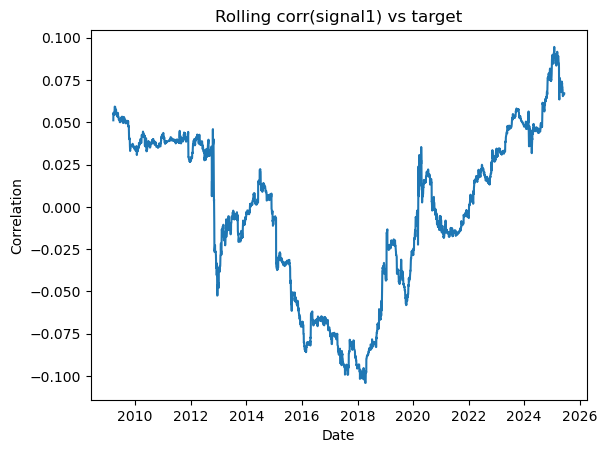

In [79]:
window = 1000

mask9 = df["target"].shift(1) < 0
cols = "MSFT_XOM_ret_diff"

x9 = df[cols].to_numpy()
# x9 = np.log1p(x9)
df["signal9"] = np.where(mask9, x9, 0)
corr1 = df["signal9"].rolling(window).corr(df["target"])
#?corr5 = pd.Series(signal9).rolling(window).corr(target)

import matplotlib.pyplot as plt

# Feature 1
plt.figure()
plt.plot(corr1)
plt.title("Rolling corr(signal1) vs target")
plt.xlabel("Date")
plt.ylabel("Correlation")

# # Feature 5
# plt.figure()
# plt.plot(corr5)
# plt.title("Rolling corr(signal5) vs target")
# plt.xlabel("Date")
# plt.ylabel("Correlation")


In [71]:
target

Date
2005-03-29    0.025103
2005-03-30   -0.026391
2005-03-31   -0.018637
2005-04-01    0.004965
2005-04-04    0.019366
                ...   
2025-06-05    0.016398
2025-06-06   -0.012113
2025-06-09    0.006056
2025-06-10   -0.019194
2025-06-11         NaN
Name: target, Length: 5050, dtype: float64

In [70]:
print(corr1)

2005-03-29 00:00:00   NaN
2005-03-30 00:00:00   NaN
2005-03-31 00:00:00   NaN
2005-04-01 00:00:00   NaN
2005-04-04 00:00:00   NaN
                       ..
5045                  NaN
5046                  NaN
5047                  NaN
5048                  NaN
5049                  NaN
Length: 10100, dtype: float64


In [ ]:

# prev_ret = df_all['target'].shift(1).abs()
# raw_x = df_all['XOM_ema3']
# signal = np.where(prev_ret > 0.01, np.log1p(raw_x), 0)

# mask2 = df_all['AMZN_XOM_ret_diff'].abs() < 0.01
# cols = ["GOOGL_ema12","GOOGL_ema6","GOOGL_roll_mean5"]

# x = df_all['GOOGL_ema12'].to_numpy()*df_all['GOOGL_ema6'].to_numpy()
# x2 = (df_all[cols]).sum(axis=1)
# x2 = np.log1p(x2)
# signal2 = np.where(mask2, x2, 0)

# mask3 = df_all['AMZN_XOM_ret_diff'].abs() < 0.007
# cols = ["GOOGL_ema12"]

# x3 = (df_all[cols]).sum(axis=1)
# x3 = np.log1p(x3)
# signal3 = np.where(mask3, x3, 0)


# mask4 = df_all['AMZN_XOM_ret_diff'].abs() < 0.003
# cols = ["AMZN_ema12"]

# x4 = (df_all[cols]).sum(axis=1)
# x4 = np.log1p(x4)
# signal4 = np.where(mask4, x4, 0)


# mask5 = df_all["XOM_ema3"].abs() < 0.05
# cols = ["AMZN_BAC_ret_diff"]

# x5 = (df_all[cols]).sum(axis=1)
# x5 = np.log1p(x5)
# signal5 = np.where(mask5, x5, 0)

# mask6 = df_all["XOM_ema3"].abs() < 0.005
# cols = ["GOOGL_roll_skew"]

# x6 = (df_all[cols]).sum(axis=1)
# x6 = np.log1p(x6)
# signal6 = np.where(mask6, x6, 0)


# mask7 = df["XOM_ema12_WMT_ema3_prod"].abs()> 0.00005
# cols = ["XOM_ema6_WMT_ema3_prod"]

# x7 = (df[cols]).sum(axis=1)
# x7 = np.log1p(x7)
# signal7 = np.where(mask7, x7, 0)


# np.abs(df_test["XOM_ema12_WMT_ema3_prod"])< 0.0001


# mask8 = df["target"].shift(1) > 0
# cols = "JPM_GLD_ret_prod"

# x8 = df[cols].to_numpy()
# # x8 = np.log1p(x8)
# signal8 = silu(x8) #np.where(mask8, x8, 0)

# mask9 = df["target"].shift(1) > 0
# cols = "AAPL_XOM_ret_prod"

# x9 = df[cols].to_numpy()
# # x9 = np.log1p(x9)
# signal9 = silu(-x9) # np.where(mask9, x9, 0)